In [114]:
import re

import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas

import datasets

# Obtaining ISO country code

In [2]:
# parse iso coutry code from html
html = \
'''
<table role="grid" aria-rowcount="250"><thead role="rowgroup" class="v-grid-header" style="transform: translate3d(0px, 0px, 0px);"><tr class="v-grid-row" role="rowheader" style="width: 1046.11px;"><th class="v-grid-cell sortable" role="columnheader" colspan="1" style="height: 30px; width: 374.725px;" aria-sort="none"><div class="v-grid-column-header-content v-grid-column-default-header-content">English short name</div></th><th class="v-grid-cell sortable sort-asc" role="columnheader" colspan="1" style="height: 30px; width: 364.038px;" aria-sort="ascending"><div class="v-grid-column-header-content v-grid-column-default-header-content">French short name</div></th><th class="v-grid-cell sortable" role="columnheader" colspan="1" style="height: 30px; width: 111.75px;" aria-sort="none"><div class="v-grid-column-header-content v-grid-column-default-header-content">Alpha-2 code</div></th><th class="v-grid-cell sortable" role="columnheader" colspan="1" style="height: 30px; width: 111.75px;" aria-sort="none"><div class="v-grid-column-header-content v-grid-column-default-header-content">Alpha-3 code</div></th><th class="v-grid-cell sortable" role="columnheader" colspan="1" style="height: 30px; width: 83.85px;" aria-sort="none"><div class="v-grid-column-header-content v-grid-column-default-header-content">Numeric</div></th></tr></thead><tbody role="rowgroup" class="v-grid-body" style="margin-top: 30px; transform: translate3d(0px, 0px, 0px);"><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 0px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Afghanistan</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Afghanistan (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AFG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">004</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 30px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">South Africa</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Afrique du Sud (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ZA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ZAF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">710</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 60px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Albania</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Albanie (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ALB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">008</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 90px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Algeria</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Algérie (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">DZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">DZA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">012</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 120px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Germany</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Allemagne (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">DE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">DEU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">276</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 150px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Andorra</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Andorre (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AND</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">020</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 180px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Angola</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Angola (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AGO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">024</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 210px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Anguilla</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Anguilla</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AIA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">660</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 240px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Antarctica</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Antarctique (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AQ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ATA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">010</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 270px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Antigua and Barbuda</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Antigua-et-Barbuda</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ATG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">028</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 300px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Saudi Arabia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Arabie saoudite (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SAU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">682</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 330px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Argentina</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Argentine (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ARG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">032</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 360px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Armenia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Arménie (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ARM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">051</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 390px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Aruba</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Aruba</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AW</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ABW</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">533</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 420px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Australia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Australie (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AUS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">036</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 450px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Austria</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Autriche (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AUT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">040</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 480px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Azerbaijan</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Azerbaïdjan (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AZE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">031</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 510px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Bahamas (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Bahamas (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BHS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">044</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 540px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Bahrain</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Bahreïn</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BH</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BHR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">048</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 570px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Bangladesh</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Bangladesh (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BGD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">050</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 600px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Barbados</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Barbade (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BRB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">052</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 630px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Belgium</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Belgique (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BEL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">056</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 660px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Belize</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Belize (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BLZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">084</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 690px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Bermuda</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Bermudes (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BMU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">060</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 720px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Bhutan</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Bhoutan (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BTN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">064</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 750px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Bolivia (Plurinational State of)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Bolivie (État plurinational de)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BOL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">068</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 780px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Bonaire, Sint Eustatius and Saba</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Bonaire, Saint-Eustache et Saba</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BQ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BES</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">535</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 810px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Bosnia and Herzegovina</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Bosnie-Herzégovine (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BIH</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">070</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 840px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Botswana</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Botswana (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BW</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BWA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">072</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 870px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Bouvet Island</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Bouvet (l'Île)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BV</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BVT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">074</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 900px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Brunei Darussalam</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Brunéi Darussalam (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BRN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">096</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 930px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Brazil</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Brésil (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BRA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">076</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 960px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Bulgaria</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Bulgarie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BGR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">100</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 990px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Burkina Faso</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Burkina Faso (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BFA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">854</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1020px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Burundi</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Burundi (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BDI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">108</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1050px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Belarus</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Bélarus (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BLR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">112</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1080px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Benin</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Bénin (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BJ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BEN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">204</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1110px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Cabo Verde</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Cabo Verde</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CV</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CPV</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">132</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1140px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Cambodia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Cambodge (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KH</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KHM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">116</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1170px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Cameroon</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Cameroun (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CMR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">120</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1200px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Canada</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Canada (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CAN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">124</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1230px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Cayman Islands (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Caïmans (les&nbsp;Îles)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CYM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">136</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1260px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Chile</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Chili (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CHL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">152</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1290px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">China</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Chine (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CHN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">156</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1320px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Christmas Island</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Christmas (l'Île)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CX</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CXR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">162</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1350px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Cyprus</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Chypre</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CYP</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">196</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1380px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Cocos (Keeling) Islands (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Cocos (les&nbsp;Îles)/ Keeling (les&nbsp;Îles)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CC</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CCK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">166</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1410px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Colombia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Colombie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">COL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">170</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1440px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Comoros (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Comores (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">COM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">174</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1470px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Congo (the Democratic Republic of the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Congo (la République démocratique du)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">COD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">180</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1500px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Congo (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Congo (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">COG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">178</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1530px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Cook Islands (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Cook (les Îles)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">COK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">184</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1560px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Korea (the Republic of)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Corée (la République de)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KOR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">410</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1590px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Korea (the Democratic People's Republic of)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Corée (la&nbsp;République populaire démocratique de)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KP</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PRK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">408</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1620px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Costa Rica</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Costa Rica (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CRI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">188</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1650px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Croatia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Croatie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">HR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">HRV</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">191</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1680px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Cuba</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Cuba</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CUB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">192</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1710px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Curaçao</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Curaçao</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CW</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CUW</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">531</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1740px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Côte d'Ivoire</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Côte d'Ivoire (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CIV</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">384</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1770px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Denmark</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Danemark (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">DK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">DNK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">208</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1800px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Djibouti</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Djibouti</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">DJ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">DJI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">262</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1830px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Dominica</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Dominique (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">DM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">DMA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">212</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1860px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">El Salvador</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">El Salvador</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SV</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SLV</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">222</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1890px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Spain</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Espagne (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ES</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ESP</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">724</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1920px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Estonia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Estonie (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">EE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">EST</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">233</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1950px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Eswatini</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Eswatini (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SWZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">748</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 1980px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Falkland Islands (the) [Malvinas]</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Falkland (les Îles)/Malouines (les Îles)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">FK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">FLK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">238</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2010px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Fiji</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Fidji (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">FJ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">FJI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">242</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2040px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Finland</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Finlande (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">FI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">FIN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">246</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2070px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">France</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">France (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">FR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">FRA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">250</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2100px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Faroe Islands (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Féroé (les Îles)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">FO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">FRO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">234</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2130px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Gabon</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Gabon (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GAB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">266</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2160px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Gambia (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Gambie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GMB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">270</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2190px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Ghana</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Ghana (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GH</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GHA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">288</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2220px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Gibraltar</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Gibraltar</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GIB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">292</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2250px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Grenada</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Grenade (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GRD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">308</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2280px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Greenland</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Groenland (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GRL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">304</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2310px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Greece</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Grèce (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GRC</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">300</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2340px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Guadeloupe</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Guadeloupe (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GP</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GLP</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">312</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2370px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Guam</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Guam</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GUM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">316</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2400px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Guatemala</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Guatemala (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GTM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">320</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2430px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Guernsey</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Guernesey</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GGY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">831</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2460px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Guinea</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Guinée (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GIN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">324</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2490px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Equatorial Guinea</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Guinée équatoriale (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GQ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GNQ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">226</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2520px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Guinea-Bissau</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Guinée-Bissau (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GW</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GNB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">624</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2550px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Guyana</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Guyana (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GUY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">328</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2580px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">French Guiana</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Guyane française (la&nbsp;)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GUF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">254</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2610px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Georgia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Géorgie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GEO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">268</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2640px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">South Georgia and the South Sandwich Islands</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Géorgie du Sud-et-les Îles Sandwich du Sud (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SGS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">239</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2670px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Haiti</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Haïti</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">HT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">HTI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">332</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2700px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Heard Island and McDonald Islands</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Heard-et-Îles MacDonald (l'Île)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">HM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">HMD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">334</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2730px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Honduras</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Honduras (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">HN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">HND</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">340</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2760px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Hong Kong</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Hong Kong</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">HK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">HKG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">344</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2790px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Hungary</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Hongrie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">HU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">HUN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">348</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2820px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">India</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Inde (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IND</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">356</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2850px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">British Indian Ocean Territory (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Indien (le&nbsp;Territoire britannique de l'océan)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IOT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">086</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2880px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Indonesia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Indonésie (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ID</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IDN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">360</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2910px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Iran (Islamic Republic of)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Iran (République Islamique d')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IRN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">364</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2940px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Iraq</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Iraq (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IQ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IRQ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">368</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 2970px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Ireland</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Irlande (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IRL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">372</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3000px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Iceland</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Islande (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ISL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">352</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3030px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Israel</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Israël</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ISR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">376</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3060px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Italy</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Italie (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ITA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">380</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3090px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Jamaica</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Jamaïque (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">JM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">JAM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">388</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3120px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Japan</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Japon (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">JP</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">JPN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">392</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3150px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Jersey</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Jersey</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">JE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">JEY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">832</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3180px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Jordan</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Jordanie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">JO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">JOR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">400</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3210px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Kazakhstan</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Kazakhstan (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KAZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">398</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3240px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Kenya</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Kenya (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KEN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">404</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3270px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Kyrgyzstan</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Kirghizistan (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KGZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">417</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3300px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Kiribati</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Kiribati</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KIR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">296</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3330px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Kuwait</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Koweït (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KW</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KWT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">414</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3360px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Lao People's Democratic Republic (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Lao (la République démocratique populaire)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LAO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">418</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3390px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Lesotho</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Lesotho (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LSO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">426</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3420px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Latvia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Lettonie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LV</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LVA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">428</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3450px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Lebanon</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Liban (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LBN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">422</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3480px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Libya</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Libye (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LBY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">434</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3510px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Liberia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Libéria (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LBR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">430</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3540px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Liechtenstein</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Liechtenstein (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LIE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">438</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3570px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Lithuania</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Lituanie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LTU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">440</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3600px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Luxembourg</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Luxembourg (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LUX</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">442</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3630px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Macao</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Macao</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MAC</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">446</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3660px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">North Macedonia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Macédoine du Nord (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MKD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">807</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3690px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Madagascar</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Madagascar</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MDG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">450</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3720px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Malaysia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Malaisie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MYS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">458</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3750px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Malawi</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Malawi (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MW</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MWI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">454</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3780px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Maldives</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Maldives (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MV</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MDV</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">462</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3810px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Mali</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Mali (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ML</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MLI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">466</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3840px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Malta</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Malte</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MLT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">470</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3870px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Northern Mariana Islands (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Mariannes du Nord (les Îles)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MP</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MNP</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">580</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3900px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Morocco</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Maroc (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MAR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">504</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3930px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Marshall Islands (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Marshall (les Îles)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MH</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MHL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">584</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3960px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Martinique</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Martinique (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MQ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MTQ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">474</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 3990px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Mauritius</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Maurice</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MUS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">480</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4020px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Mauritania</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Mauritanie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MRT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">478</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4050px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Mayotte</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Mayotte</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">YT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MYT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">175</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4080px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Mexico</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Mexique (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MX</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MEX</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">484</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4110px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Micronesia (Federated States of)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Micronésie (États fédérés de)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">FM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">FSM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">583</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4140px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Moldova (the Republic of)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Moldova (la République de)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MDA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">498</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4170px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Monaco</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Monaco</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MC</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MCO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">492</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4200px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Mongolia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Mongolie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MNG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">496</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4230px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Montserrat</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Montserrat</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MSR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">500</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4260px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Montenegro</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Monténégro (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ME</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MNE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">499</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4290px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Mozambique</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Mozambique (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MOZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">508</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4320px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Myanmar</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Myanmar (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MMR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">104</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4350px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Namibia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Namibie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NAM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">516</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4380px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Nauru</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Nauru</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NRU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">520</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4410px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Nicaragua</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Nicaragua (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NIC</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">558</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4440px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Niger (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Niger (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NER</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">562</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4470px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Nigeria</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Nigéria (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NGA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">566</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4500px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Niue</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Niue</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NIU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">570</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4530px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Norfolk Island</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Norfolk (l'Île)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NFK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">574</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4560px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Norway</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Norvège (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NOR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">578</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4590px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">New Caledonia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Nouvelle-Calédonie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NC</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NCL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">540</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4620px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">New Zealand</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Nouvelle-Zélande (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NZL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">554</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4650px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Nepal</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Népal (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NP</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NPL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">524</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4680px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Oman</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Oman</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">OM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">OMN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">512</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4710px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Uganda</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Ouganda (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">UG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">UGA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">800</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4740px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Uzbekistan</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Ouzbékistan (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">UZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">UZB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">860</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4770px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Pakistan</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Pakistan (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PAK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">586</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4800px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Palau</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Palaos (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PW</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PLW</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">585</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4830px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Palestine, State of</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Palestine, État de</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PSE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">275</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4860px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Panama</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Panama (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PAN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">591</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4890px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Papua New Guinea</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Papouasie-Nouvelle-Guinée (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PNG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">598</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4920px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Paraguay</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Paraguay (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PRY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">600</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4950px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Netherlands (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Pays-Bas (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">NLD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">528</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 4980px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Philippines (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Philippines (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PH</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PHL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">608</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5010px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Pitcairn</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Pitcairn</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PCN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">612</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5040px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Poland</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Pologne (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">POL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">616</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5070px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">French Polynesia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Polynésie française (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PYF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">258</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5100px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Puerto Rico</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Porto Rico</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PRI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">630</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5130px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Portugal</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Portugal (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PRT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">620</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5160px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Peru</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Pérou (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PER</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">604</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5190px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Qatar</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Qatar (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">QA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">QAT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">634</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5220px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Romania</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Roumanie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">RO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ROU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">642</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5250px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">United Kingdom of Great Britain and Northern Ireland (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Royaume-Uni de Grande-Bretagne et d'Irlande du Nord (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">GBR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">826</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5280px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Russian Federation (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Russie (la Fédération de)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">RU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">RUS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">643</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5310px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Rwanda</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Rwanda (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">RW</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">RWA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">646</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5340px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Syrian Arab Republic (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">République arabe syrienne (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SYR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">760</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5370px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Central African Republic (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">République centrafricaine (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CAF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">140</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5400px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Réunion</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Réunion (La)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">RE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">REU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">638</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5430px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Western Sahara*</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Sahara occidental (le)*</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">EH</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ESH</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">732</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5460px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Saint Barthélemy</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Saint-Barthélemy</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">BLM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">652</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5490px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Saint Kitts and Nevis</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Saint-Kitts-et-Nevis</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">KNA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">659</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5520px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">San Marino</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Saint-Marin</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SMR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">674</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5550px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Saint Martin (French part)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Saint-Martin (partie française)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">MAF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">663</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5580px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Sint Maarten (Dutch part)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Saint-Martin (partie néerlandaise)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SX</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SXM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">534</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5610px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Saint Pierre and Miquelon</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Saint-Pierre-et-Miquelon</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">PM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SPM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">666</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5640px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Holy See (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Saint-Siège (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VAT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">336</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5670px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Saint Vincent and the Grenadines</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Saint-Vincent-et-les Grenadines</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VC</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VCT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">670</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5700px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Saint Helena, Ascension and Tristan da Cunha</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Sainte-Hélène, Ascension et Tristan da Cunha</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SH</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SHN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">654</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5730px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Saint Lucia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Sainte-Lucie</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LC</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LCA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">662</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5760px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Solomon Islands</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Salomon (les Îles)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SLB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">090</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5790px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Samoa</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Samoa (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">WS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">WSM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">882</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5820px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">American Samoa</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Samoa américaines (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ASM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">016</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5850px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Sao Tome and Principe</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Sao Tomé-et-Principe</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ST</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">STP</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">678</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5880px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Serbia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Serbie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">RS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SRB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">688</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5910px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Seychelles</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Seychelles (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SC</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SYC</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">690</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5940px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Sierra Leone</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Sierra Leone (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SLE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">694</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 5970px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Singapore</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Singapour</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SGP</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">702</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6000px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Slovakia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Slovaquie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SVK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">703</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6030px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Slovenia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Slovénie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SVN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">705</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6060px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Somalia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Somalie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SOM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">706</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6090px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Sudan (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Soudan (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SDN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">729</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6120px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">South Sudan</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Soudan du Sud (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SSD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">728</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6150px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Sri Lanka</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Sri Lanka</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">LKA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">144</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6180px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Switzerland</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Suisse (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CH</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CHE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">756</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6210px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Suriname</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Suriname (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SUR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">740</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6240px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Sweden</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Suède (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SWE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">752</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6270px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Svalbard and Jan Mayen</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Svalbard et l'Île Jan Mayen (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SJ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SJM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">744</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6300px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Senegal</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Sénégal (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">SEN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">686</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6330px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Tajikistan</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Tadjikistan (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TJ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TJK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">762</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6360px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Tanzania, the United Republic of</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Tanzanie (la République-Unie de)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TZA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">834</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6390px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Taiwan (Province of China)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Taïwan (Province de Chine)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TW</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TWN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">158</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6420px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Chad</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Tchad (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TCD</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">148</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6450px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Czechia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Tchéquie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CZ</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">CZE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">203</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6480px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">French Southern Territories (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Terres australes françaises (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ATF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">260</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6510px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Thailand</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Thaïlande (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TH</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">THA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">764</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6540px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Timor-Leste</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Timor-Leste (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TLS</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">626</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6570px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Togo</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Togo (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TGO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">768</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6600px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Tokelau</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Tokelau (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TK</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TKL</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">772</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6630px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Tonga</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Tonga (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TON</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">776</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6660px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Trinidad and Tobago</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Trinité-et-Tobago (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TTO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">780</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6690px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Tunisia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Tunisie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TUN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">788</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6720px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Turkmenistan</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Turkménistan (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TKM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">795</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6750px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Turks and Caicos Islands (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Turks-et-Caïcos (les Îles)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TC</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TCA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">796</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6780px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Turkey</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Turquie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TUR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">792</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6810px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Tuvalu</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Tuvalu (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TV</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">TUV</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">798</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6840px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Ukraine</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Ukraine (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">UA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">UKR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">804</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6870px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Uruguay</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Uruguay (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">UY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">URY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">858</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6900px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Vanuatu</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Vanuatu (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VUT</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">548</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6930px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Venezuela (Bolivarian Republic of)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Venezuela (République bolivarienne du)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VEN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">862</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6960px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Virgin Islands (British)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Vierges britanniques (les&nbsp;Îles)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VGB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">092</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 6990px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Virgin Islands (U.S.)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Vierges des États-Unis (les Îles)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VIR</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">850</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7020px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Viet Nam</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Viet Nam (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">VNM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">704</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7050px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Wallis and Futuna</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Wallis-et-Futuna </td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">WF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">WLF</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">876</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7080px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Yemen</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Yémen (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">YE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">YEM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">887</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7110px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Zambia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Zambie (la)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ZM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ZMB</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">894</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7140px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Zimbabwe</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Zimbabwe (le)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ZW</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ZWE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">716</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7170px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Dominican Republic (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">dominicaine (la&nbsp;République)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">DO</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">DOM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">214</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7200px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Åland Islands</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Åland(les Îles)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AX</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ALA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">248</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7230px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Egypt</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Égypte (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">EG</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">EGY</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">818</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7260px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">United Arab Emirates (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Émirats arabes unis (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">AE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ARE</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">784</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7290px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Ecuador</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Équateur (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">EC</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ECU</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">218</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7320px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Eritrea</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Érythrée (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ER</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ERI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">232</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7350px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">United States of America (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">États-Unis d'Amérique (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">US</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">USA</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">840</td></tr><tr class="v-grid-row v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7380px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Ethiopia</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Éthiopie (l')</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ET</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">ETH</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">231</td></tr><tr class="v-grid-row v-grid-row-stripe v-grid-row-has-data" role="row" style="width: 1046.11px; transform: translate3d(0px, 7410px, 0px);"><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">Isle of Man</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Île de Man</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">IMN</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">833</td></tr><tr class="v-grid-row v-grid-row-has-data v-grid-row-focused" role="row" style="width: 1046.11px; transform: translate3d(0px, 7440px, 0px);"><td class="v-grid-cell wrap v-grid-cell-focused" role="gridcell" colspan="1" style="height: 30px; width: 374.725px;"><button type="button" class="v-nativebutton" style="">United States Minor Outlying Islands (the)</button></td><td class="v-grid-cell wrap" role="gridcell" colspan="1" style="height: 30px; width: 364.038px;">Îles mineures éloignées des États-Unis (les)</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">UM</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 111.75px;">UMI</td><td class="v-grid-cell" role="gridcell" colspan="1" style="height: 30px; width: 83.85px;">581</td></tr></tbody><tfoot role="rowgroup" class="v-grid-footer" style="transform: translate3d(0px, 0px, 0px);"></tfoot></table>
'''
soup = BeautifulSoup(html, 'html.parser')
table = []
for tr in soup.find_all('tr')[1:]:
    row = []
    for td in tr.find_all('td'):
        row.append(td.string)
    table.append(row)

iso_a3 = pd.DataFrame(table, columns=['English short name', 'French short name', 'Alpha-2 code', 'Alpha-3 code', 'Numeric'])
iso_a3.head()

,English short name,French short name,Alpha-2 code,Alpha-3 code,Numeric
0,Afghanistan,Afghanistan (l'),AF,AFG,004
1,South Africa,Afrique du Sud (l'),ZA,ZAF,710
2,Albania,Albanie (l'),AL,ALB,008
3,Algeria,Algérie (l'),DZ,DZA,012
4,Germany,Allemagne (l'),DE,DEU,276


In [3]:
# mapping from index in the datasets to iso English short name
mapping = {
    'Bahamas': 'Bahamas (the)',
    'Burma': 'Myanmar',
    'Bolivia': 'Bolivia (Plurinational State of)',
    'Bosnia': 'Bosnia and Herzegovina',
    'British Virgin Islands': 'Virgin Islands (British)',
    'Brunei': 'Brunei Darussalam',
    'Cape Verde': 'Cabo Verde',
    'Cayman Islands': 'Cayman Islands (the)',
    'Central African Republic': 'Central African Republic (the)',
    "Cote d'Ivoire": "Côte d'Ivoire",
    'Congo Republic': 'Congo (the)',
    'Congo (Brazzaville)': 'Congo (the)',
    'Congo (Kinshasa)': 'Congo (the Democratic Republic of the)',
    'Czech Republic': 'Czechia',
    'DR Congo': 'Congo (the Democratic Republic of the)',
    'Dominican Republic': 'Dominican Republic (the)',
    'Gambia': 'Gambia (the)',
    'The Gambia': 'Gambia (the)',
    'Laos':  "Lao People's Democratic Republic (the)",
    'Holy See': 'Holy See (the)',
    'South Korea': 'Korea (the Republic of)',
    'Korea, South': 'Korea (the Republic of)',
    'Macau': 'Macao',
    'Moldova': 'Moldova (the Republic of)',
    'Netherlands': 'Netherlands (the)',
    'Niger': 'Niger (the)',
    'Iran': 'Iran (Islamic Republic of)',
    'Philippines': 'Philippines (the)',
    'Palestine': 'Palestine, State of',
    'Russia': 'Russian Federation (the)',
    'Sudan': 'Sudan (the)',
    'Syria':  'Syrian Arab Republic (the)',
    'United Arab Emirates': 'United Arab Emirates (the)',
    'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland (the)',
    'US': 'United States of America (the)',
    'United States': 'United States of America (the)',
    'St. Barthélemy': 'Saint Barthélemy',
    'St. Kitts and Nevis': 'Saint Kitts and Nevis',
    'Sint Maarten': 'Sint Maarten (Dutch part)',
    'Tanzania': 'Tanzania, the United Republic of',
    'Taiwan': 'Taiwan (Province of China)',
    'Taiwan*': 'Taiwan (Province of China)',
    'Turks and Caicos Islands': 'Turks and Caicos Islands (the)',
    'Vietnam': 'Viet Nam',
    'Venezuela': 'Venezuela (Bolivarian Republic of)',
    'West Bank and Gaza': 'Palestine, State of',
}

# Loading datasets

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[world.name!="Antarctica"]

In [6]:
df_pomber = datasets.pomber()
today = df_pomber.groupby('Country').last()
today.head()

,Cases,Deaths,Recovered
Country,,,
Afghanistan,273,6,10
Albania,277,16,76
Algeria,986,86,61
Andorra,428,15,10
Angola,8,2,1


In [7]:
df_bno = datasets.bno()
df_bno.head()

,Cases,New cases,Deaths,New deaths,Death rate,Serious & Critical,Recovered
WORLD,,,,,,,
United States,274650.0,29879.0,7315.0,1243.0,2.66,5176.0,10864.0
Italy,119827.0,4585.0,14681.0,766.0,12.25,4068.0,19758.0
Spain,119199.0,7134.0,11198.0,850.0,9.39,6092.0,26743.0
Germany,91203.0,6081.0,1306.0,199.0,1.43,2424.0,30230.0
China,83269.0,84.0,3322.0,4.0,3.99,379.0,76745.0


In [8]:
def mapper(country):
    if country in mapping:
        return mapping[country]
    return country

# conform with iso country name
# datasets are merges with iso_a3 on country code
today.rename(index=mapper, inplace=True)
df_bno.rename(index=mapper, inplace=True)

In [9]:
# world should be merged with the (datasets, iso_a3) on iso_a3
(world.shape,
 world.merge(iso_a3, left_on='iso_a3', right_on='Alpha-3 code').shape,
 world.merge(iso_a3, left_on='name', right_on='English short name').shape)

((176, 6), (171, 11), (137, 11))

## Names that are not found in ISO mapping

In [10]:
set(today.index) - set(iso_a3['English short name'])

{'Diamond Princess', 'Kosovo', 'MS Zaandam'}

In [11]:
set(df_bno.index) - set(iso_a3['English short name'])

{'Diamond Princess',
 'Ivory Coast',
 'Kosovo',
 'Northern Cyprus',
 'Vatican City'}

# Merging DataFrames

In [12]:
intermediate_today = today.merge(iso_a3[['English short name', 'Alpha-3 code']],
                                 left_index=True, right_on='English short name', how='left')
final_today = world[['iso_a3', 'geometry']].merge(intermediate_today,left_on='iso_a3',
                                                  right_on='Alpha-3 code',how='left')
final_today.head()

,iso_a3,geometry,Cases,Deaths,Recovered,English short name,Alpha-3 code
0,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",7.0,0.0,0.0,Fiji,FJI
1,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",20.0,1.0,2.0,"Tanzania, the United Republic of",TZA
2,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN
3,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",11284.0,139.0,1735.0,Canada,CAN
4,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",243453.0,5926.0,9001.0,United States of America (the),USA


In [13]:
intermediate_bno = df_bno.merge(iso_a3[['English short name', 'Alpha-3 code']],
                                left_index=True, right_on='English short name', how='left')
final_bno = world[['iso_a3', 'geometry']].merge(intermediate_bno,left_on='iso_a3',
                                                right_on='Alpha-3 code',how='left')
final_bno.head()

,iso_a3,geometry,Cases,New cases,Deaths,New deaths,Death rate,Serious & Critical,Recovered,English short name,Alpha-3 code
0,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",7.0,0.0,0.0,0.0,0.00,NaN,0.0,Fiji,FJI
1,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",20.0,1.0,1.0,0.0,5.00,NaN,1.0,"Tanzania, the United Republic of",TZA
2,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",12496.0,1213.0,183.0,45.0,1.46,84.0,2189.0,Canada,CAN
4,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",274650.0,29879.0,7315.0,1243.0,2.66,5176.0,10864.0,United States of America (the),USA


# Plotting

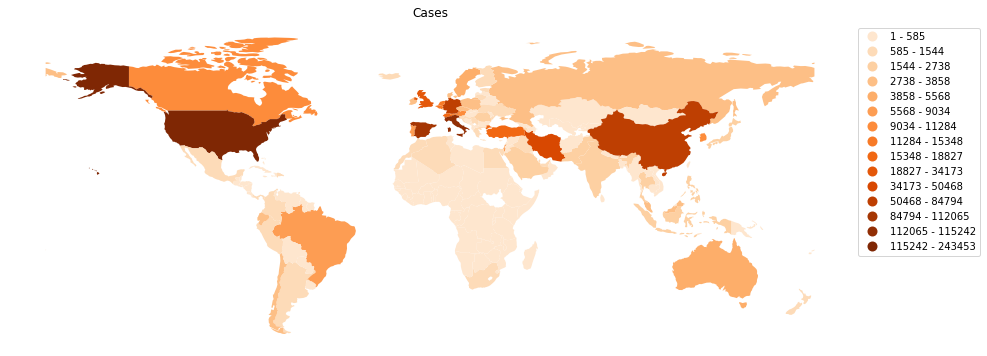

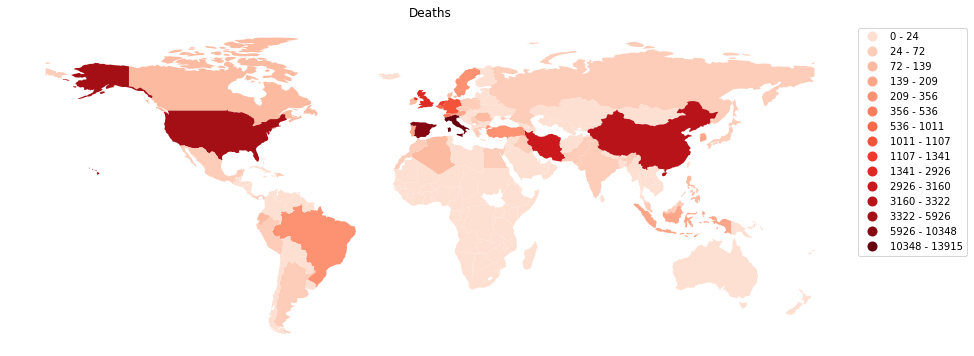

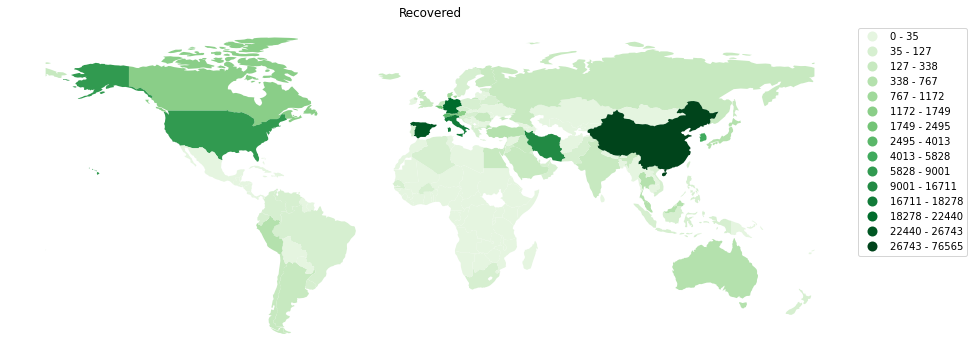

In [120]:
ws = re.compile('\.\d{2}')

def plot_map(data, category, cmap):
    fig, ax = plt.subplots(figsize=(18, 6))
    data.plot(column=category, ax=ax, legend=True, scheme='NaturalBreaks', k=15, cmap=cmap, vmin=-2,
#               missing_kwds={"color": "lightgrey"},
              legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)})
    ax.set_title(category)
    ax.axis('off')
    legend = ax.get_legend()
    for text in legend.get_texts():
        text.set_text(re.sub(ws, '', text.get_text()))
    plt.show()

plot_map(final_today, 'Cases', 'Oranges')
plot_map(final_today, 'Deaths', 'Reds')
plot_map(final_today, 'Recovered', 'Greens')